In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [31]:
# Read in data # df --> dataframe
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [32]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

Text(0.5, 0, 'Review Stars')

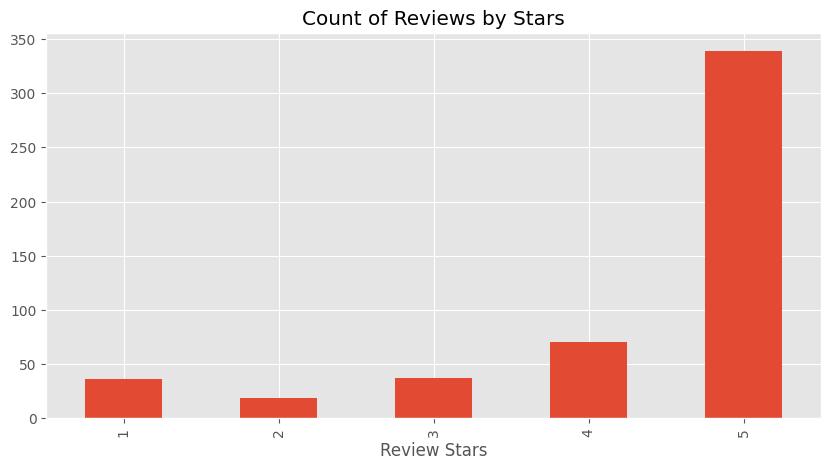

In [34]:
# value_counts gives the number of times each score occurs
axis = df['Score'].value_counts().sort_index().plot(kind='bar',
                                           title='Count of Reviews by Stars',
                                           figsize=(10,5))
axis.set_xlabel('Review Stars')

## BASIC NLTK

In [35]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [37]:
# Split sentence into parts of each word
# More accurate and readable (by computer) than splitting on spaces

tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [39]:
# pos_tag --> part of speech tag
tagged = nltk.pos_tag(tokens)
tagged[:10]

# DT --> Determiner
# NN --> Singular Noun
# JJ --> Adjective
# PRP --> Preposition

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [41]:
# Take tokens and group them into chunks of text
# pprint() --> Pretty print (print data structues in a readable way)
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER
Valence Aware Dictionary (and) sEntiment Reasoner

Takes each word and assigns a positive, negative, or neutral value. Then, for all words, it'll add up to communicate if the sentence ahs a positive, negative, or neutral sentiment.

NOTES:
Does not account for relationships between words, which is very important in human speech

Stop words (ie. and, the) are removed
 


In [49]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Progress bar tracker for loops on data
from tqdm.notebook import tqdm

# Sentiment Intensity Analyzer Object

sia = SentimentIntensityAnalyzer()

In [45]:
sia.polarity_scores('I am so happy!')

# No negative, some neutral, mostly positive --> Accurate
# Compound value ranges from -1 to 1 and represents how negative to positive it is

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [47]:
sia.polarity_scores('This is the worst thing ever.')

# Fairly negative, mostly neutral (likely because of "." over "!"), and no positive
# Compound value shows its negative overall

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [48]:
sia.polarity_scores(example)

# Overall negative (compund score)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [53]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [58]:
# Pandas (pd) DataFrame frames the data
# .T flips the frame horizontally
# Indexs are ids

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [59]:
# Now, the table has sentiment score and metadata
vaders.head()

# Can track accuracy of sentiment analysis based off star rating of review

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.000,0.554,0.446,0.9725,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,0.059,0.791,0.150,0.8215,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,0.025,0.762,0.212,0.9848,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,0.041,0.904,0.055,0.1280,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


## Plot VADER Results

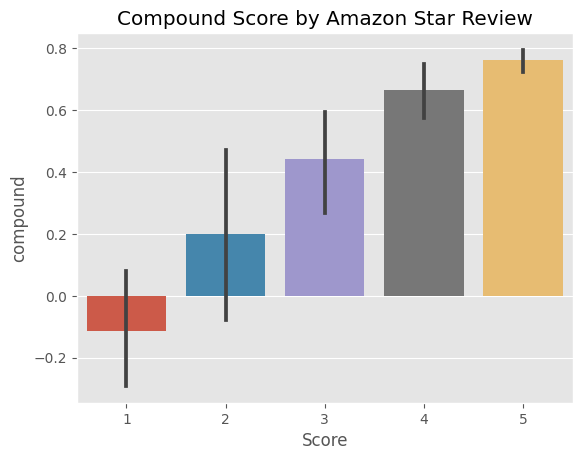

In [63]:
# "compound" must NOT be capatalized --> that's how it is outputted in sia
axis = sns.barplot(data=vaders, x='Score', y='compound')
axis.set_title('Compound Score by Amazon Star Review')
plt.show()

# Table shows lower star reviews have lower compound scores, and higher star reviews have higher compound scores


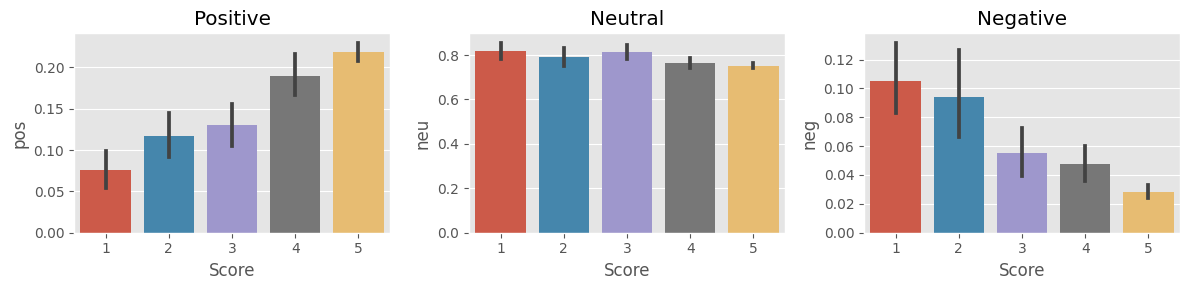

In [68]:
# Make barplots for each pos, neg, neu

# Make a 1x3 grid
fig, axs = plt.subplots(1,3,figsize=(12,3))
# Figure size is simply the size of each cell

# Create plots
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu',ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])

# Titles
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show() 


Graphs validate VADER

For positive, the more stars a review has, the more postiive the sentiment is. The less stars a review has, the less positive the sentiment is.

For neutral, the scores are even.

For negative, the more stars a review has, the less negative the sentiment is. The less stars a review has, the more negative the sentiment is.